In [1]:
#Load the data for a station and organize
import pandas as pd
import numpy as np
import math
from datetime import datetime
import os
# Path to data files
ipd = "D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\"

#Organize the data based on the nature of the data so they all conform to the same size matrices
#The metrics included are
#  AT - air temperature in Celcius
#  RH - relative humidity in Percent
#  PR - precipitation in MM

#Identify which stations are in folder and have all three metrics
#List only files
files = [entry.name for entry in os.scandir(ipd) if entry.is_file()]

print(files)

def assign_flags(name, pattern):
    return int(pattern in name.lower())

# Example usage:
# Unique_stations
df_files = pd.DataFrame(files,columns=['File_name'])
# Extract the station ID from the file names
df_files['stid'] = df_files['File_name'].apply(lambda x: x.split('_')[0])
df_files['has_airtem'] = df_files['File_name'].apply(assign_flags, pattern='airtemp')
df_files['has_precip'] = df_files['File_name'].apply(assign_flags, pattern='precip')
df_files['has_relhum'] = df_files['File_name'].apply(assign_flags, pattern='relhum')
df_files['has_all3'] = df_files[['has_airtem', 'has_precip', 'has_relhum']].sum(axis=1)

#All the available stations which have all three metrics needed for model
vc_stid = df_files[['stid','has_all3']].drop_duplicates()
#vc_stid <- vc_stid[1]

#print(df_files)
print(vc_stid)

def keep_max_by_keys(df, keys):
    """
    Given a DataFrame and a list of keys, keep the maximum value for all other columns grouped by the keys.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    keys (list): The list of column names to group by.

    Returns:
    pd.DataFrame: A DataFrame with the maximum values for each group.
    """
    return df.groupby(keys).max().reset_index()

# keep_max_by_keys(df_files, ['stid'])

['72502014734_model_data_airtemp.csv', '72502014734_model_data_precip.csv', '72502014734_model_data_relhum.csv', '72504094702_model_data_airtemp.csv', '72504094702_model_data_precip.csv', '72504094702_model_data_relhum.csv', '72505004781_model_data_airtemp.csv', '72505004781_model_data_precip.csv', '72505004781_model_data_relhum.csv', '72508014740_model_data_airtemp.csv', '72508014740_model_data_precip.csv', '72508014740_model_data_relhum.csv', '72508014740_test.parquet', '72508014740_train.parquet', '72508014740_validation.parquet', '72510094746_model_data_airtemp.csv', '72510094746_model_data_precip.csv', '72510094746_model_data_relhum.csv', '74486094789_airtemp.csv', '74486094789_model_data_airtemp.csv', '74486094789_model_data_precip.csv', '74486094789_model_data_relhum.csv', '74486094789_precip.csv', '74486094789_relhum.csv', '74736093042_model_data_airtemp.csv', '74736093042_model_data_precip.csv', '74736093042_model_data_relhum.csv', '74739013961_model_data_airtemp.csv', '747390

In [2]:
def fn_make_matrix_pr(stid,ipd,nhours,ndays,nyears_row,nyears_col):

    #Create a matrix for precipitation data that feeds
    #The S4 model
    # 1. Read in all data files
    # 2. Find the common starting date that will be used to align the matrices
    # 3. Keep only the values that fit the common starting date
    # 4. Combine the data into one large matrix for the StationID 

    # 1. Read in data files and get start date v_date... for each
    # Check that data exist for all metrics

    #Air temperature (one variable recorded once an hour a day)
    df_at = pd.read_csv(ipd + stid + "_airtemp.csv")
    v_date_at = datetime.strptime(df_at.iloc[0,2], "%Y-%m-%d").date()
    #Relative Hunidity (3 variables recorded once a day)
    df_rh = pd.read_csv(ipd + stid + "_relhum.csv")
    v_date_rh = datetime.strptime(df_rh.iloc[0,4], "%Y-%m-%d").date()
    #Precipitation (one variable recorded once an hour a day)
    df_pr = pd.read_csv(ipd + stid + "_precip.csv")
    v_date_pr = datetime.strptime(df_pr.iloc[0,2], "%Y-%m-%d").date()


    # 2. Find the offsets needed to all datasets start at same starting date
    v_date_minimum = min(v_date_at,v_date_rh,v_date_pr)
    v_date_minimum

    #Identify offsets to use so all datadata vectors are appropriately aligned 
    offset_at = -(v_date_minimum - v_date_at).days
    offset_rh = -(v_date_minimum - v_date_rh).days
    offset_pr = -(v_date_minimum - v_date_pr).days

    # 3. Get vectors of data for each measure
    #These vectors all start on the same date
    vc_at1 = df_at.iloc[offset_at:(len(df_at.iloc[:,1])-offset_at),1]
    vc_rh1 = df_rh.iloc[offset_rh:(len(df_rh.iloc[:,1])-offset_rh),1]
    vc_rh2 = df_rh.iloc[offset_rh:(len(df_rh.iloc[:,2])-offset_rh),2]
    vc_rh3 = df_rh.iloc[offset_rh:(len(df_rh.iloc[:,3])-offset_rh),3]
    vc_pr1 = df_pr.iloc[offset_pr:(len(df_pr.iloc[:,1])-offset_pr),1]


    # 4. Interleave vectors so we get a complete vector of all metrics
    #Start with the once a day vectors and loop over the number of days as defined by once a day vector
    # These set how many years of data are needed : nyears_row + nyears_col
    nyears_data_limit = nyears_row + nyears_col + 1
    nrows = nhours*ndays*nyears_row
    ncols = nhours*ndays*nyears_col 
    
    # set the number of metrics created each day
    # Metrics measured at hourly intervals are put into day metrics
    # And ordered from most recent hour to most distant hour from left to right
    # Day metrics are also ordered most recent day to most distant day left to right
    ndaily_metrics = 2*nhours + 3*1

    #Set the total number of days of data needed for the model
    num_days = nyears_data_limit*ndays
    #print(f"Number of days: {num_days}")

    is_first = 1

    #Construct the vector that holds all data values (valid and missing)
    for i_day in range(num_days):
        i_day_hour_end = (i_day + 1)*nhours - 1
        i_day_hour_start = i_day_hour_end - (nhours -1)
        va = vc_pr1[(i_day_hour_start + offset_pr):(i_day_hour_end + offset_pr)]
        vb = vc_rh1[(i_day + offset_rh):(i_day + offset_rh)]
        vc = vc_rh2[(i_day + offset_rh):(i_day + offset_rh)]
        vd = vc_rh3[(i_day + offset_rh):(i_day + offset_rh)]
        ve = vc_at1[(i_day_hour_start + offset_pr):(i_day_hour_end + offset_pr)]

        #vmt_full set = np.concatenate((vmt_one_day,va,vb,vc,vd,ve)) 
        #print(i_day)
        if is_first == 0:
            vmt_full_set = np.concatenate((vmt_full_set,va,vb,vc,vd,ve))
            #print(len(vmt_full_set))
        else:
            is_first = 0
            vmt_full_set = np.concatenate((va,vb,vc,vd,ve))
            #print(len(vmt_full_set))

    #print(f"Length of data vector: {len(vmt_full_set)}")


    #Organize the data vector into an array which will be returned to the function call
    #Create an empty matrix in which data are organized
    nrows = nyears_row*ndays
    ncols = nyears_col*ndays*ndaily_metrics
    nrow_days =  nyears_row*ndays
    ncol_days =  nyears_col*ndays
    data_limit = len(vmt_full_set)
    #print(f"Number of columns in matrix: {ncols}")
    #print(f"Limit of data: {data_limit}")

    #Make template matrix to house data
    template_matrix = np.zeros((nrows, ncols), dtype=np.float16)

    # Fill the matrix
    for i in range(nrow_days):
        vc_start = i*(ndaily_metrics)
        vc_end = ncols + vc_start
        
        if vc_end < data_limit:
            template_matrix[i] = vmt_full_set[(vc_start):(vc_end)]

    #   print(vc_start)
    #   print(vc_end)
    #   print(len(vmt_full_set[(vc_start):(vc_end)]))
        
    return template_matrix


In [3]:
#Put them all in appropriate matrices and create list of metrics
#Data files are of two types
#    -  24 hour * 365 days * n years  (AT, PR)
#    -  365 days * n years (RH)

#Parameters governing data matrix
nhours = 24
ndays = 365
nyears_row = 10
nyears_col = 3

def get_matrix(in_stid):
    return fn_make_matrix_pr(in_stid,ipd,nhours,ndays,nyears_row,nyears_col)

#lst_matrix = list(map(get_matrix,vc_stid.iloc[1,0]))

#print(lst_matrix)
#print(jj.shape)

jj = fn_make_matrix_pr("74486094789",ipd,nhours,ndays,nyears_row,nyears_col)

C:\Users\prajw\AppData\Local\Temp\ipykernel_10080\2135009217.py:14: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_at = pd.read_csv(ipd + stid + "_airtemp.csv")
C:\Users\prajw\AppData\Local\Temp\ipykernel_10080\2135009217.py:20: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pr = pd.read_csv(ipd + stid + "_precip.csv")


In [5]:
def transform_matrix(df, bins, labels):
    """
    Transforms the given matrix by binning the first column, dropping the first row and column,
    and adding the binned column as the first column.

    Parameters:
        matrix (pd.DataFrame): The input matrix.

    Returns:
        pd.DataFrame: The transformed matrix.
    """
    # Extract the first column (dependent variable)
    firstcolumn = df.iloc[:, 0].astype('float32')

    # Bin the first column
    binned_column = pd.cut(firstcolumn, bins=bins, labels=labels)

    # Drop the first first column
    df = df.iloc[:, 1:]

    # Add the binned column as the first column
    df.insert(0, 0, binned_column.iloc[0:].values)

    # Return the final matrix
    return df

# Example usage
# Example matrix (replace this with your actual matrix)
df = pd.DataFrame(jj).iloc[1:,] # Convert to DataFrame and drop the first row for binning
fc = df.iloc[:,0].astype('float32') # Ensure the first column is float for binning
# bins = [-float('inf'), 0] + list(pd.qcut(fc[fc > 0], q=2, retbins=True)[1][1:]) + [float('inf')]
bins = [-float('inf'), 10, float('inf')]
labels = [0, 1]
# print(bins, labels)

df_transformed = transform_matrix(df, bins, labels)
df_transformed = df_transformed[df_transformed[0]>= 0]
# df_transformed[0].value_counts(dropna=False).sort_index()
# df_transformed.shape

In [6]:
df_transformed[0].value_counts(dropna=False).sort_index()

0
0    2524
1    1090
Name: count, dtype: int64

In [7]:
def split_time_series_data(df, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    """
    Splits a time series dataset into training, validation, and test sets.

    Parameters:
        df (pd.DataFrame): The input time series dataset, ordered in descending dates.
        train_ratio (float): The proportion of data to use for training.
        val_ratio (float): The proportion of data to use for validation.
        test_ratio (float): The proportion of data to use for testing.

    Returns:
        tuple: A tuple containing three DataFrames (train, validation, test).
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"

    # Calculate split indices
    n = len(df)
    test_end = int(n * test_ratio)    
    val_end = test_end + int(n * val_ratio)
    

    # Split the data
    test_data = df.iloc[:test_end].sort_index(ascending=False)
    val_data = df.iloc[test_end:val_end].sort_index(ascending=False)
    train_data = df.iloc[val_end:].sort_index(ascending=False)


    return train_data, val_data, test_data

# Example usage
train_data, val_data, test_data = split_time_series_data(df_transformed)
print("Training Set:", train_data.shape)
print("Validation Set:", val_data.shape)
print("Test Set:", test_data.shape)

Training Set: (2531, 55845)
Validation Set: (361, 55845)
Test Set: (722, 55845)


In [ ]:
# Define the station ID and output directory
station_id = "74486094789"
output_dir = "D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\"

# Export datasets to CSV
train_data.to_parquet(f"{output_dir}{station_id}_train.parquet", index=False)
val_data.to_parquet(f"{output_dir}{station_id}_validation.parquet", index=False)
test_data.to_parquet(f"{output_dir}{station_id}_test.parquet", index=False)

# Export datasets to CSV
# train_data.to_csv(f"{output_dir}{station_id}_train.csv", index=False)
# val_data.to_csv(f"{output_dir}{station_id}_validation.csv", index=False)
# test_data.to_csv(f"{output_dir}{station_id}_test.csv", index=False)

print("Datasets exported successfully.")

#python -m s4model --modelname 74486094789 --trainset ../data/weathermetrics/74486094789_train.csv --valset ../data/weathermetrics/74486094789_validation.csv --testset ../data/weathermetrics/74486094789_test.csv --tabulardata --dependent_variable 0 --epochs 30
#python -m s4model --modelname 74486094789 --trainset ../data/weathermetrics/74486094789_train.parquet --valset ../data/weathermetrics/74486094789_validation.parquet --testset ../data/weathermetrics/74486094789_test.parquet --tabulardata --dependent_variable 0 --epochs 30

# python -m charts --df ../results/74486094789_Test_results_20250408_093735PM.csv --actual 0 --predicted Predicted 
# python -m charts --df ../results/74486094789_Test_results_20250414_103853PM.csv --actual 0 --predicted Predicted 
# python -m charts --df ../results/74486094789_Test_results_20250415_082627PM.csv --actual 0 --predicted Predicted 
# python -m charts --df ../results/74486094789_Test_results_20250415_083725PM.csv --actual 0 --predicted Predicted 


In [117]:
df = pd.DataFrame(jj)
df =df.iloc[1:,:] # Remove first row of zeros which is a template row
print(df.head())

      0         1         2         3         4         5         6      \
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  1.500000  0.700195  1.299805  1.799805  1.000000  0.300049  0.000000   
3  1.000000  0.500000  0.300049  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  3.300781  3.300781  4.449219  5.000000   
5  3.050781  3.900391  5.000000  3.300781  3.300781  2.199219  1.150391   

      7         8         9      ...     55835      55836  55837     55838  \
1  0.000000  0.000000  2.000000  ...  16.09375  15.000000   15.0  16.09375   
2  0.000000  0.000000  0.300049  ...   0.00000   0.000000    0.0   0.00000   
3  0.000000  8.898438  9.398438  ...   0.50000   0.799805    0.0   0.00000   
4  5.000000  5.300781  5.000000  ...   0.00000   0.000000    0.0   0.00000   
5  0.600098 -1.099609 -3.300781  ...   0.00000   0.000000    0.0   0.00000   

   55839     55840  55841      55842      55843      55844  
1    0.0  0.000000 

(2190,)


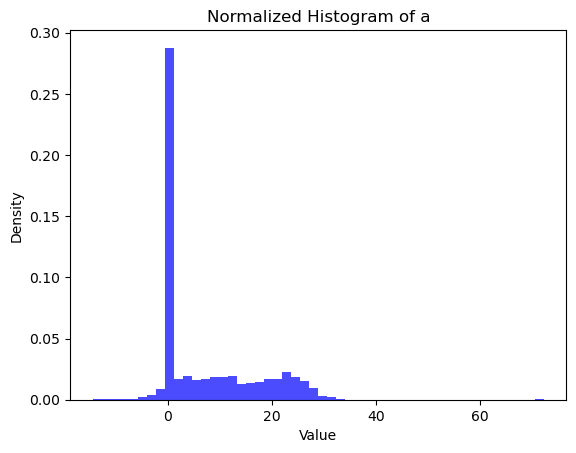

In [109]:
df = pd.DataFrame(jj)
fc = df.iloc[:,0].astype('float32')
print(fc.shape)
import matplotlib.pyplot as plt

plt.hist(fc, bins=50, color='blue', alpha=0.7, density=True)
plt.title('Normalized Histogram of a')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


In [110]:
# Custom bins
a = fc  # Convert to float32 to avoid issues with float16 precision
# bins = [-float('inf'), 0, 2, 5, float('inf')]
# labels = ['Low', 'Medium', 'High', 'Very High']
# a_categorized = pd.cut(a, bins=bins, labels=labels)

# Quantile-based bins
# Ensure unique bin edges by adding a small epsilon to duplicate edges
# unique_a = a + np.random.uniform(0, 1e-10, size=len(a))
# a_categorized = pd.qcut(unique_a, q=5, labels=[0, 1, 2, 3, 4])

# print(a_categorized.value_counts())

# quantile_cuts = pd.qcut(unique_a, q=5, retbins=True, precision= 1)[1]
# print("Quantile Cuts:", quantile_cuts)


# Domain-specific thresholds
bins = [-float('inf'), 0, 2.5, 7.6, float('inf')]
labels = ['00. No Rain', '01. Light Rain', '02. Moderate Rain', '03. Heavy Rain']

a_categorized = pd.cut(a, bins=bins, labels=labels, right=True)
print(a_categorized.value_counts())

combined = pd.DataFrame({'Value': a, 'Category': a_categorized})

# print(combined.head())
# Convert to string for better readability in the output
combined['Category'] = combined['Category'].astype(str)
combined['Value'] = combined['Value'].astype(str)

b = pd.DataFrame(combined.groupby(['Category', 'Value']).size()).sort_index()

0
00. No Rain          1048
03. Heavy Rain        777
02. Moderate Rain     195
01. Light Rain        139
Name: count, dtype: int64


In [ ]:
# Define bins for less than or equal to zero as "No Rain" and quantile-based bins for the rest
bins = [-float('inf'), 0] + list(pd.qcut(a[a > 0], q=4, retbins=True)[1][1:]) + [float('inf')]
labels = ['00. No Rain', '01. Light Rain', '02. Moderate Rain', '03. Heavy Rain', '04. Very Heavey Rain', '05. Really Heavy Rain']
labels = [0, 1, 2, 3, 4, 5]
print(labels)
print("Bin Boundaries:", bins)

# Apply the new binning
a_categorized = pd.cut(a, bins=bins, labels=labels, right=True)
print(a_categorized.value_counts())

# Combine the categorized data with the original values
combined = pd.DataFrame({'Value': a, 'Category': a_categorized})

# Convert to string for better readability in the output
combined['Category'] = combined['Category'].astype(str)
combined['Value'] = combined['Value'].astype(str)

b = pd.DataFrame(combined.groupby(['Category', 'Value']).size()).sort_index()

# Print the boundaries for the bins



[0, 1, 2, 3, 4, 5]
Bin Boundaries: [-inf, 0, 6.69921875, 13.296875, 21.09375, 52.1875, inf]
1
0    27012
1     7403
3     7139
2     6774
4     6726
5        0
Name: count, dtype: int64


In [73]:
combined['Value'].value_counts(dropna= False).sort_index()

Value
-0.25            7
-0.30004883     38
-0.41992188      1
-0.5498047      10
-0.60009766    178
              ... 
9.796875         3
9.8359375        1
9.875            1
9.8984375        3
nan            791
Name: count, Length: 662, dtype: int64

In [15]:
from datetime import timedelta
import polars as pl

def parse_value_and_calculate_datetime(value, reference_date):
    """
    Parses the value and calculates the target variable, number of days, hours, 
    and the datetime difference based on the reference date.

    Parameters:
    value (str): The input value in the format 'ATD000044H23'.
    reference_date (datetime.date): The reference date.

    Returns:
    tuple: A tuple containing the target variable (str), number of days (int), 
           number of hours (int), and the calculated datetime (datetime.datetime).
    """
    # Extract the target variable (first two characters)
    target_variable = value[:2]
    
    # Extract the number of days (characters after 'D' and before 'H')
    days_str = value.split('D')[1].split('H')[0]
    num_days = int(days_str) - 1  # Subtract 1 to match the logic in the original code
    
    # Extract the number of hours (characters after 'H')
    hours_str = value.split('H')[1]
    num_hours = 24 - int(hours_str)
    
    # Calculate the datetime difference
    delta = timedelta(days=num_days, hours=num_hours)
    calculated_datetime = datetime.combine(reference_date, datetime.min.time()) - delta
    
    return target_variable, num_days, num_hours, calculated_datetime

# def get_data_and_reference_date(location, stationid, filename):
#     # Determine file extension and read the file accordingly
#     file_path = location + stationid + filename
#     if filename.endswith('.csv'):
#         df = pl.read_csv(file_path)
#     elif filename.endswith('.parquet'):
#         df = pl.read_parquet(file_path)
#     else:
#         raise ValueError("Unsupported file format. Only .csv and .parquet are supported.")
    
#     # Extract the reference date from the first row
#     reference_date = datetime.strptime(df['ref_date'][0], "%Y-%m-%d").date()
    
#     # Use parse_value_and_calculate to calculate the date column
#     df = df.with_columns(
#         pl.col('var_name').apply(lambda x: parse_value_and_calculate_datetime(x, reference_date)[3]).alias('date')
#     )
    
#     # Drop the original variable name and reference date columns if needed
#     df = df.drop(['var_name', 'ref_date'])
    
#     # Set the date column as index and sort by date
#     df = df.sort('date').set_sorted('date')
    
#     # Forward fill to make the dataset hourly if it is not
#     df = df.groupby_dynamic('date', every='1h').agg(pl.all().forward_fill())
    
#     return df, reference_date

# parse_value_and_calculate_datetime("ATD000044H23", ref_date_at)


def get_data_and_reference_date(location, stationid, filename):
    file_path = f"{location}{stationid}{filename}"
    
    # Get reference date using lazy evaluation
    ref_date_query = (
        pl.scan_csv(file_path) if filename.endswith('.csv') 
        else pl.scan_parquet(file_path)
    ).select(pl.col("ref_date").first())
    
    reference_date = datetime.strptime(
        ref_date_query.collect().item(),
        "%Y-%m-%d"
    ).date()

    # Main processing pipeline (corrected map_elements and group_by_dynamic)
    lf = (
        pl.scan_csv(file_path) if filename.endswith('.csv') 
        else pl.scan_parquet(file_path)
    ).with_columns(
        pl.col("var_name").map_elements(
            lambda x: parse_value_and_calculate_datetime(x, reference_date)[3],
            return_dtype=pl.Datetime
        ).alias("date")
    ).drop(["var_name", "ref_date"]).sort("date").set_sorted("date")

    # Corrected group_by_dynamic spelling and aggregation
    resampled = lf.group_by_dynamic(
        index_column="date",
        every="1h",
        closed="left",
        include_boundaries=False
    ).agg(
        pl.all().fill_null(strategy="forward")
    )

    return resampled.collect(engine='streaming'), reference_date

In [ ]:
stid = '74486094789'
# Air temperature
df_at, ref_date_at = get_data_and_reference_date(ipd, stid, "_airtemp.csv")
# Relative Humidity
df_rh, ref_date_rh = get_data_and_reference_date(ipd, stid, "_relhum.csv")
# Precipitation
df_pr, ref_date_pr = get_data_and_reference_date(ipd, stid, "_precip.csv")

print("Air Temperature Reference Date:", ref_date_at)
print("Relative Humidity Reference Date:", ref_date_rh)
print("Precipitation Reference Date:", ref_date_pr)

# 2. Find the offsets needed to all datasets start at same starting date
ref_date_minimum = min(ref_date_at,ref_date_rh, ref_date_pr)
ref_date_minimum
print("Minimum Reference Date:", ref_date_minimum)

min_date = min(df_rh.index.min(), df_at.index.min(), df_pr.index.min())
max_date = max(df_rh.index.max(), df_at.index.max(), df_pr.index.max())
print("Minimum Date in Data:", min_date)
print("Maximum Date in Data:", max_date)

combined_df = pd.DataFrame(index=pd.date_range(
    start=min_date,
    end=max_date,
    freq='H')).join([df_at, df_rh, df_pr], how='left')

Air Temperature Reference Date: 2025-02-13
Relative Humidity Reference Date: 2025-02-13
Precipitation Reference Date: 2025-02-13
Minimum Reference Date: 2025-02-13


In [24]:
def combine_datasets_on_datetime(datasets, datetime_key="date"):
    """
    Combines multiple datasets on a datetime key, keeping all available data.

    Parameters:
    datasets (list of pl.LazyFrame): List of LazyFrames to combine.
    datetime_key (str): The key to join on, typically a datetime column.

    Returns:
    pl.DataFrame: Combined DataFrame with all available data.
    """
    # Start with the first dataset
    combined = datasets[0]

    # Iteratively join all datasets on the datetime key
    for dataset in datasets[1:]:
        combined = combined.join(dataset, on=datetime_key, how="full")

    # Collect the result into a DataFrame
    return combined.collect()

# Example usage:
# Assuming df_at, df_pr, and df_rh are LazyFrames
datasets = [df_at.lazy(), df_pr.lazy() #, df_rh.lazy()
            ]
combined_df = combine_datasets_on_datetime(datasets)

# Print the result
print(combined_df)

shape: (271_752, 4)
┌─────────────────────┬───────────────────────┬─────────────────────┬─────────────────────┐
│ date                ┆ air_temp_degrees_cels ┆ date_right          ┆ precip_depth_sum_mm │
│ ---                 ┆ ---                   ┆ ---                 ┆ ---                 │
│ datetime[μs]        ┆ list[f64]             ┆ datetime[μs]        ┆ list[f64]           │
╞═════════════════════╪═══════════════════════╪═════════════════════╪═════════════════════╡
│ 1994-01-01 00:00:00 ┆ [-0.6]                ┆ 1994-01-01 00:00:00 ┆ [0.0]               │
│ 1994-01-01 01:00:00 ┆ [-1.1]                ┆ 1994-01-01 01:00:00 ┆ [0.0]               │
│ 1994-01-01 02:00:00 ┆ [-1.1]                ┆ 1994-01-01 02:00:00 ┆ [0.0]               │
│ 1994-01-01 03:00:00 ┆ [-1.7]                ┆ 1994-01-01 03:00:00 ┆ [0.0]               │
│ 1994-01-01 04:00:00 ┆ [-1.7]                ┆ 1994-01-01 04:00:00 ┆ [0.0]               │
│ …                   ┆ …                     ┆ …           

C:\Users\prajw\AppData\Local\Temp\ipykernel_22332\1067836617.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  combined_df = pd.DataFrame(index=pd.date_range(


In [72]:
print(combined_df.loc['2024-10-01'])

                     air_temp_degrees_cels  Max_RH_pct  Rel_Hum_pct  \
2024-10-01 00:00:00                  17.50        97.0         84.0   
2024-10-01 01:00:00                  17.20        97.0         84.0   
2024-10-01 02:00:00                  16.10        97.0         84.0   
2024-10-01 03:00:00                  16.40        97.0         84.0   
2024-10-01 04:00:00                  16.10        93.0         59.0   
2024-10-01 05:00:00                  16.10         NaN          NaN   
2024-10-01 06:00:00                  15.85         NaN          NaN   
2024-10-01 07:00:00                  15.60         NaN          NaN   
2024-10-01 08:00:00                  16.10         NaN          NaN   
2024-10-01 09:00:00                  16.10         NaN          NaN   
2024-10-01 10:00:00                  16.10         NaN          NaN   
2024-10-01 11:00:00                  16.70         NaN          NaN   
2024-10-01 12:00:00                  17.50         NaN          NaN   
2024-1

In [ ]:
#Identify offsets to use so all datadata vectors are appropriately aligned 
offset_at = -(ref_date_minimum - ref_date_at).days
offset_rh = -(ref_date_minimum - ref_date_rh).days
offset_pr = -(ref_date_minimum - ref_date_pr).days

# 3. Get vectors of data for each measure
#These vectors all start on the same date
vc_at1 = df_at.iloc[offset_at:(len(df_at.iloc[:,1])-offset_at),1]
vc_rh1 = df_rh.iloc[offset_rh:(len(df_rh.iloc[:,1])-offset_rh),1]
vc_rh2 = df_rh.iloc[offset_rh:(len(df_rh.iloc[:,2])-offset_rh),2]
vc_rh3 = df_rh.iloc[offset_rh:(len(df_rh.iloc[:,3])-offset_rh),3]
vc_pr1 = df_pr.iloc[offset_pr:(len(df_pr.iloc[:,1])-offset_pr),1]

('AT', 44, 23, datetime.date(2024, 12, 31))

In [ ]:
df_at.iloc[offset_at:(len(df_at.iloc[:,1])-offset_at),1]

0          9.4
1          8.9
2          9.7
3         10.0
4         11.7
          ... 
271726    -1.7
271727    -1.7
271728    -1.1
271729    -1.1
271730    -0.6
Name: air_temp_degrees_cels, Length: 271731, dtype: float64

In [7]:
# 4. Interleave vectors so we get a complete vector of all metrics
#Start with the once a day vectors and loop over the number of days as defined by once a day vector
# These set how many years of data are needed : nyears_row + nyears_col
nyears_data_limit = nyears_row + nyears_col + 1
nrows = nhours*ndays*nyears_row
ncols = nhours*ndays*nyears_col 

print(nyears_data_limit, nrows, ncols)

10 52560 26280


In [ ]:
# 4. Interleave vectors so we get a complete vector of all metrics
#Start with the once a day vectors and loop over the number of days as defined by once a day vector
# These set how many years of data are needed : nyears_row + nyears_col
nyears_data_limit = nyears_row + nyears_col + 1
nrows = nhours*ndays*nyears_row
ncols = nhours*ndays*nyears_col 

# set the number of metrics created each day
# Metrics measured at hourly intervals are put into day metrics
# And ordered from most recent hour to most distant hour from left to right
# Day metrics are also ordered most recent day to most distant day left to right
ndaily_metrics = 2*nhours + 3*1

#Set the total number of days of data needed for the model
num_days = nyears_data_limit*ndays
#print(f"Number of days: {num_days}")

is_first = 1

#Construct the vector that holds all data values (valid and missing)
for i_day in range(num_days):
    i_day_hour_end = (i_day + 1)*nhours - 1
    i_day_hour_start = i_day_hour_end - (nhours -1)
    va = vc_pr1[(i_day_hour_start + offset_pr):(i_day_hour_end + offset_pr)]
    vb = vc_rh1[(i_day + offset_rh):(i_day + offset_rh)]
    vc = vc_rh2[(i_day + offset_rh):(i_day + offset_rh)]
    vd = vc_rh3[(i_day + offset_rh):(i_day + offset_rh)]
    ve = vc_at1[(i_day_hour_start + offset_pr):(i_day_hour_end + offset_pr)]

    #vmt_full set = np.concatenate((vmt_one_day,va,vb,vc,vd,ve)) 
    #print(i_day)
    if is_first == 0:
        vmt_full_set = np.concatenate((vmt_full_set,va,vb,vc,vd,ve))
        #print(len(vmt_full_set))
    else:
        is_first = 0
        vmt_full_set = np.concatenate((va,vb,vc,vd,ve))
        #print(len(vmt_full_set))

#print(f"Length of data vector: {len(vmt_full_set)}")


#Organize the data vector into an array which will be returned to the function call
#Create an empty matrix in which data are organized
nrows = nyears_row*ndays
ncols = nyears_col*ndays*ndaily_metrics
nrow_days =  nyears_row*ndays
ncol_days =  nyears_col*ndays
data_limit = len(vmt_full_set)
#print(f"Number of columns in matrix: {ncols}")
#print(f"Limit of data: {data_limit}")

#Make template matrix to house data
template_matrix = np.zeros((nrows, ncols), dtype=np.float16)

# Fill the matrix
for i in range(nrow_days):
    vc_start = i*(ndaily_metrics)
    vc_end = ncols + vc_start
    
    if vc_end < data_limit:
        template_matrix[i] = vmt_full_set[(vc_start):(vc_end)]

#   print(vc_start)
#   print(vc_end)
#   print(len(vmt_full_set[(vc_start):(vc_end)]))

In [ ]:
# Define the station ID and output directory
station_id = "74486094789"
output_dir = "D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\"

# Export datasets to CSV
train_data.to_csv(f"{output_dir}{station_id}_train.csv", index=False)
val_data.to_csv(f"{output_dir}{station_id}_validation.csv", index=False)
test_data.to_csv(f"{output_dir}{station_id}_test.csv", index=False)

print("Datasets exported successfully.")
